# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme(style="darkgrid")

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.linear_model import SGDClassifier, LogisticRegression
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler, PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV, SequentialFeatureSelector

## Part 1: Titanic survival prediction

### Dataset

Read the description here: https://www.kaggle.com/c/titanic/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/titanic/overview/evaluation.  


In [3]:
PATH = "./data/"

In [4]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [5]:
data.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
PassengerId,,,,,,,,,,,
1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [6]:
print(f'All numbers: \n{data["Sex"].value_counts().to_string()}\n\n\
Survived: \n{data[data["Survived"] == 1]["Sex"].value_counts().to_string()}\n\n\
Percentage of survived among: \n\
{round((data[data["Survived"] == 1]["Sex"].value_counts() / data["Sex"].value_counts() * 100), 2).to_string()}')

All numbers: 
male      577
female    314

Survived: 
female    233
male      109

Percentage of survived among: 
female    74.20
male      18.89


Well, the percentage of survivors among females is much higher than among males. Probably the men decided to stay on the ship, giving up their places in the lifeboats.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

Mean for survived: 28.34
Mean for deceased: 30.63
Median for survived: 28.00
Median for deceased: 28.00


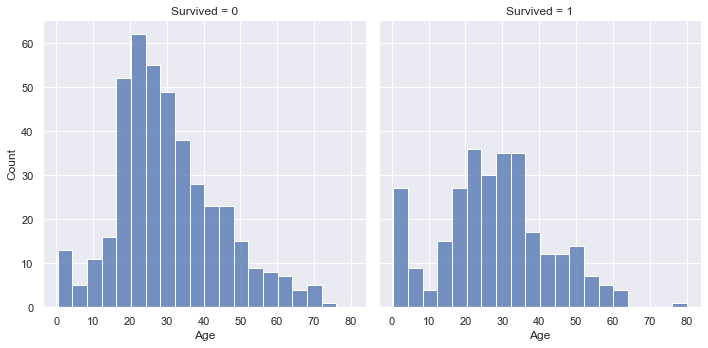

In [7]:
print(f'Mean for survived: {data[data["Survived"] == 1]["Age"].mean():.2f}')
print(f'Mean for deceased: {data[data["Survived"] == 0]["Age"].mean():.2f}')
print(f'Median for survived: {data[data["Survived"] == 1]["Age"].median():.2f}')
print(f'Median for deceased: {data[data["Survived"] == 0]["Age"].median():.2f}')
sns.displot(data, x='Age', col='Survived');

Mean for survived slightly less than for deceased. Median is the same. Among the survivors we can see a large number of children under 5 years old. Perhaps because children were first loaded into lifeboats.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

Percentage of survived for each passenger class:
1    62.96
2    47.28
3    24.24

Percentage of survived for each embarkation port:
S    33.70
C    55.36
Q    38.96


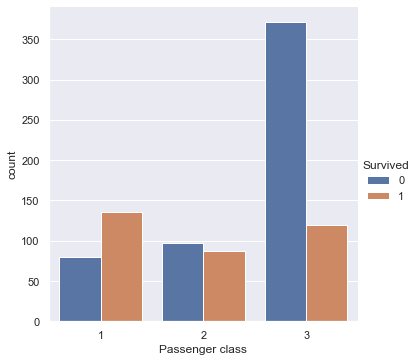

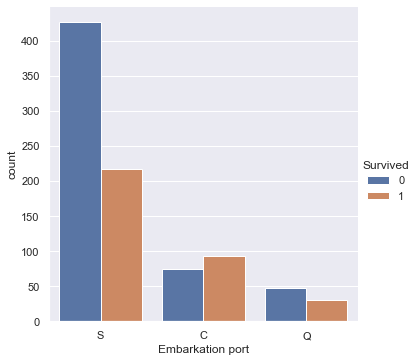

In [8]:
print(f"Percentage of survived for each passenger class:\n\
{round(data[data['Survived'] == 1]['Pclass'].value_counts() / data['Pclass'].value_counts() * 100, 2).to_string()}\n")
print(f"Percentage of survived for each embarkation port:\n\
{round(data[data['Survived'] == 1]['Embarked'].value_counts() / data['Embarked'].value_counts() * 100, 2).to_string()}")
sns.catplot(data=data, x='Pclass', hue="Survived", kind="count").set_axis_labels('Passenger class')
sns.catplot(data=data, x='Embarked', hue="Survived", kind="count").set_axis_labels('Embarkation port');

We can see that "safest class" is first class. And many survived among those who boarded the ship in the port of Cherbourg.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [9]:
round(data.isna().sum() / data.shape[1], 2)

Survived     0.00
Pclass       0.00
Name         0.00
Sex          0.00
Age         16.09
SibSp        0.00
Parch        0.00
Ticket       0.00
Fare         0.00
Cabin       62.45
Embarked     0.18
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

In column 'Cabin' more than 60% of data is NA. We will drop this feature from training set. In column 'Age' 16% of data NA. We will replace it with median value of column. In 'Embarked' we'll replace NA with most frequent value of column, because this is categorical feature.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [10]:
y = data['Survived']
X = data.drop(['Survived', 'Name', 'Ticket', 'Cabin'], axis=1)

In [11]:
numeric_features = ['Age', 'SibSp', 'Parch', 'Fare']
categorical_features = ['Pclass', 'Sex', 'Embarked']

def preprocessor(numeric_features, categorical_features):
    numeric_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())])

    categorical_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='most_frequent')),
        ('encoder', OneHotEncoder(handle_unknown='ignore'))])

    return ColumnTransformer(
        transformers=[
            ('num', numeric_transformer, numeric_features),
            ('cat', categorical_transformer, categorical_features)])

log_reg_model = Pipeline([
    ('preprocessor', preprocessor(numeric_features, categorical_features)),
    ('classifier', LogisticRegression(solver='liblinear', penalty='l1'))])

print(f"Accuracy of logistic regression model: \
{cross_validate(log_reg_model, X, y, cv=5, scoring='accuracy')['test_score'].mean()}")

knn_model = Pipeline([
    ('preprocessor', preprocessor(numeric_features, categorical_features)),
    ('classifier', KNeighborsClassifier(n_neighbors=12))])

print(f"Accuracy of KNN model: {cross_validate(knn_model, X, y, cv=5, scoring='accuracy')['test_score'].mean()}")

Accuracy of logistic regression model: 0.7901324461741259
Accuracy of KNN model: 0.8092084614901764


The accuracy of the KNN model is slightly higher than that of the logistic regression model.

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

In [12]:
# Add to our model feature selection
log_reg_sel_model = Pipeline([
    ('preprocessor', preprocessor(numeric_features, categorical_features)),
    ('selector', SelectFromModel(LogisticRegression(solver='liblinear', penalty='l1', C=0.1))),  
    ('classifier', LogisticRegression(solver='liblinear', penalty='l1'))])

print(f"Accuracy of logistic regression with feature selection: \
{cross_validate(log_reg_sel_model, X, y, cv=5, scoring='accuracy')['test_score'].mean()}")

Accuracy of logistic regression with feature selection: 0.7912560416797438


In [13]:
# Add to our model polynomial feature
log_reg_poly_sel_model = Pipeline([
    ('preprocessor', preprocessor(numeric_features, categorical_features)),
    ('polynomial', PolynomialFeatures(degree=2)),
    ('selector', SelectFromModel(LogisticRegression(solver='liblinear', penalty='l1', C=0.1))),  
    ('classifier', LogisticRegression(solver='liblinear', penalty='l1'))])

print(f"Accuracy of logistic regression with polynomial feature and feature selection: \
{cross_validate(log_reg_poly_sel_model, X, y, cv=5, scoring='accuracy')['test_score'].mean()}")

Accuracy of logistic regression with polynomial feature and feature selection: 0.8114682066411399


Let's try to save the 'Cabin' feature. We can to assume that everyone who survived was able to name their cabin number, and those who did not survive could not. Let's make 'Cabin' a categorical feature (0 if NA, 1 if it has any value).

Percentage of survived for 'Cabin' = 1: 66.67
Percentage of survived for 'Cabin' = 0: 29.99


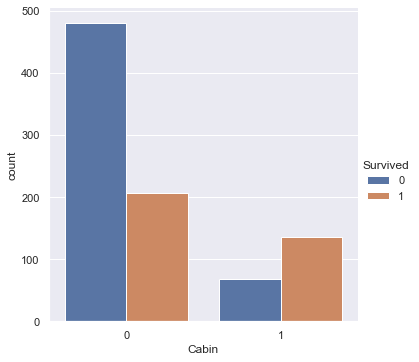

In [14]:
X = data.drop(['Name', 'Ticket'], axis=1)
X['Cabin'] = X['Cabin'].fillna(0).apply(lambda x: 1 if (x != 0) else 0)
print(f"Percentage of survived for 'Cabin' = 1: \
{round(X[(X['Cabin'] == 1) & (X['Survived'] == 1)].shape[0] / X[X['Cabin'] == 1].shape[0] * 100, 2)}")
print(f"Percentage of survived for 'Cabin' = 0: \
{round(X[(X['Cabin'] == 0) & (X['Survived'] == 1)].shape[0] / X[X['Cabin'] == 0].shape[0] * 100, 2)}")
sns.catplot(data=X, x='Cabin', hue="Survived", kind="count");
X = X.drop(['Survived'], axis=1)

Well, it looks like we've found a relationship between 'Cabin' and 'Survived'. And our assumption turned out to be correct. Let's train our models on updated data.

In [15]:
categorical_features = ['Pclass', 'Sex', 'Embarked', 'Cabin']

log_reg_poly_sel_model = Pipeline([
    ('preprocessor', preprocessor(numeric_features, categorical_features)),
    ('polynomial', PolynomialFeatures(degree=2)),
    ('selector', SelectFromModel(LogisticRegression(solver='liblinear', penalty='l1', C=0.1))), 
    ('classifier', LogisticRegression(solver='liblinear', penalty='l1'))])

print(f"Accuracy of logistic regression with polynomial feature and feature selection: \
{cross_validate(log_reg_poly_sel_model, X, y, cv=5, scoring='accuracy')['test_score'].mean()}")

Accuracy of logistic regression with polynomial feature and feature selection: 0.8204381394764922


In [16]:
# Do the same for KNN model
knn_poly_sel_model = Pipeline([
    ('preprocessor', preprocessor(numeric_features, categorical_features)),
    ('polynomial', PolynomialFeatures(degree=2)),
    ('selector', SelectFromModel(LogisticRegression(solver='liblinear', penalty='l1', C=0.1))),
    ('classifier', KNeighborsClassifier(n_neighbors=12))])

print(f"Accuracy of KNN model: {cross_validate(knn_poly_sel_model, X, y, cv=5, scoring='accuracy')['test_score'].mean()}")

Accuracy of KNN model: 0.8114556525014123


The accuracy of our models has been improved!

Load the test set and make the predictions. Submit them to kaggle and see the results :)
Select the best model, load the test set and make the predictions. Submit them to kaggle.

**Note**. X points will depend on your kaggle leaderboard score.
$$ f(score) = 0.5, \ \ 0.76 \leq score < 0.78,$$
$$ f(score) = 1.0, \ \ 0.78 \leq score < 0.81,$$ 
$$ f(score) = 2.5, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

Logistic regression with polynomial feature and feature selection showed the best accuracy. We select it to be sent to Kaggle.

In [17]:
test_data = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv')).set_index('PassengerId')
X_test = test_data.drop(['Name', 'Ticket'], axis=1)
X_test['Cabin'] = X_test['Cabin'].fillna(0).apply(lambda x: 1 if (x != 0) else 0)
y_pred = log_reg_poly_sel_model.fit(X, y).predict(X_test)
result = pd.DataFrame({'PassengerId': test_data.index, 'Survived': y_pred})
result.to_csv('Alex_Lytin_submission_titanic.csv', index=False)

The accuracy of our submission on Kaggle was 0.78468 (username: aliaksandrlytsin). Not great, not terrible...